In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

## Loading King County, Washington, Real Estate Data Set

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

**Cursory Examination of data set**

In [3]:
df_last25yrs = df.loc[df['yr_built'] > 1990]
df_last25yrs.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,NO,NONE,...,7 Average,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570
16,1875500060,7/31/2014,395000.0,3,2.00,1890,14040,2.0,NO,NONE,...,7 Average,1890,0.0,1994,0.0,98019,47.7277,-121.962,1890,14018
22,7137970340,7/3/2014,285000.0,5,2.50,2270,6300,2.0,NO,NONE,...,8 Good,2270,0.0,1995,0.0,98092,47.3266,-122.169,2240,7005
29,1873100390,3/2/2015,719000.0,4,2.50,2570,7173,2.0,NO,NONE,...,8 Good,2570,0.0,2005,0.0,98052,47.7073,-122.110,2630,6026
30,8562750320,11/10/2014,580500.0,3,2.50,2320,3980,2.0,NO,NONE,...,8 Good,2320,0.0,2003,0.0,98027,47.5391,-122.070,2580,3980
31,2426039314,12/1/2014,280000.0,2,1.50,1190,1265,3.0,NO,NONE,...,7 Average,1190,0.0,2005,0.0,98133,47.7274,-122.357,1390,1756
39,2078500320,6/20/2014,605000.0,4,2.50,2620,7553,2.0,NO,NONE,...,8 Good,2620,0.0,1996,0.0,98056,47.5301,-122.180,2620,11884
40,5547700270,7/15/2014,625000.0,4,2.50,2570,5520,2.0,NaN,NONE,...,9 Better,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669


In [4]:
df_last25yrs['yr_built'].describe()

count    6671.000000
mean     2003.469045
std         6.572641
min      1991.000000
25%      1999.000000
50%      2004.000000
75%      2008.000000
max      2015.000000
Name: yr_built, dtype: float64

In [5]:
df_last25yrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6671 entries, 5 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6671 non-null   int64  
 1   date           6671 non-null   object 
 2   price          6671 non-null   float64
 3   bedrooms       6671 non-null   int64  
 4   bathrooms      6671 non-null   float64
 5   sqft_living    6671 non-null   int64  
 6   sqft_lot       6671 non-null   int64  
 7   floors         6671 non-null   float64
 8   waterfront     5953 non-null   object 
 9   view           6651 non-null   object 
 10  condition      6671 non-null   object 
 11  grade          6671 non-null   object 
 12  sqft_above     6671 non-null   int64  
 13  sqft_basement  6671 non-null   object 
 14  yr_built       6671 non-null   int64  
 15  yr_renovated   5503 non-null   float64
 16  zipcode        6671 non-null   int64  
 17  lat            6671 non-null   float64
 18  long   

<AxesSubplot:>

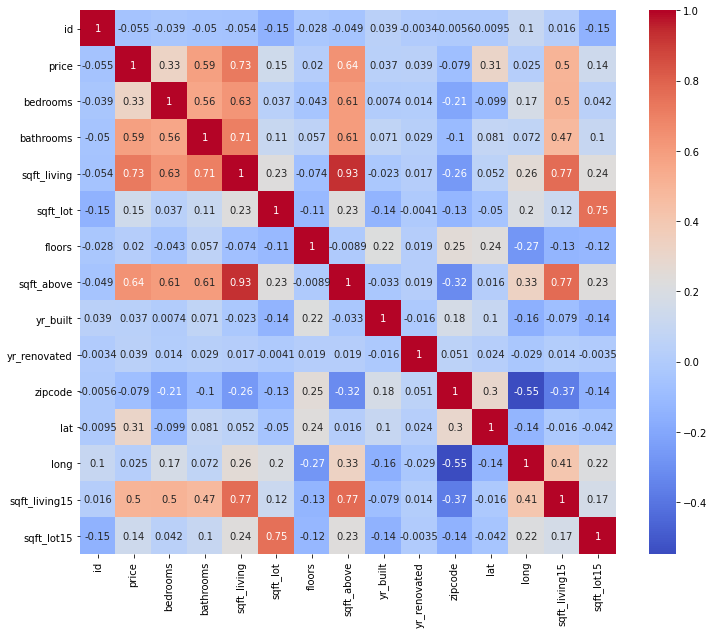

In [6]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_last25yrs.corr(), cmap = 'coolwarm', annot = True)

In [7]:
df_last25yrs_corr = df_last25yrs.corr()['price'].map(abs).sort_values(ascending=False)
df_last25yrs_corr

price            1.000000
sqft_living      0.725602
sqft_above       0.637644
bathrooms        0.587883
sqft_living15    0.498861
bedrooms         0.325806
lat              0.312860
sqft_lot         0.146344
sqft_lot15       0.136687
zipcode          0.078915
id               0.054905
yr_renovated     0.038864
yr_built         0.036964
long             0.024744
floors           0.019580
Name: price, dtype: float64

**Observations:**  
Looks like 'price' is the only dependant variable.
'sqft_living' is the most closely correlated variable to 'price'.
'sqft_above' and 'sqft_living15' also have correlation but they may be closely correlated to each other.
'bathrooms' also seems to have correlation to 'price'.
Curiously, 'bedrooms' is not very correlated to 'price'.

In [8]:
y = df_last25yrs['price']
X = df_last25yrs['sqft_living']

sqft_living_model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
sqft_living_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     7415.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        14:44:37   Log-Likelihood:                -93318.
No. Observations:                6671   AIC:                         1.866e+05
Df Residuals:                    6669   BIC:                         1.867e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.246e+05   9225.518    -13.509      0.000   -1.43e+05   -1.07e+05
sqft_living   296.3958      3.442     86.113      0.000     289.648     303.143
==============================================================================
Omnibus:                     4996.293   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187970.555
Skew:                           3.201   Prob(JB):                         0.00
Kurtosis:                      28.204   Cond. No.                     7.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
len(df_last25yrs)

6671

In [10]:
df_last25yrs[['price', 'sqft_living']].describe()

,price,sqft_living
count,6.671000e+03,6671.000000
mean,6.095944e+05,2477.180782
std,4.181423e+05,1023.647976
min,1.540000e+05,550.000000
25%,3.600000e+05,1690.000000
50%,5.000000e+05,2330.000000
75%,7.200000e+05,3040.000000
max,6.890000e+06,13540.000000


In [11]:
n=len(df_last25yrs)
s_mean= df_last25yrs['sqft_living'].mean()
std = df_last25yrs['sqft_living'].std()

t_value = stats.t.ppf(.975, df=n-1)
std_err = std/np.sqrt(n)
margin_error = t_value * std_err
int_min = s_mean - margin_error
int_max = s_mean + margin_error

print(t_value, std, std_err)

1.9603197108445463 1023.6479756768894 12.53300351874715


In [12]:
y = df_last25yrs['price']
X = df_last25yrs['bedrooms']

bedrooms_model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
bedrooms_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     792.0
Date:                Wed, 11 May 2022   Prob (F-statistic):          9.31e-165
Time:                        14:44:37   Log-Likelihood:                -95438.
No. Observations:                6671   AIC:                         1.909e+05
Df Residuals:                    6669   BIC:                         1.909e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.46e+04    2.1e+04      1.648      0.099   -6560.702    7.58e+04
bedrooms     1.64e+05   5825.790     28.142      0.000    1.53e+05    1.75e+05
==============================================================================
Omnibus:                     5743.953   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           259059.244
Skew:                           3.926   Prob(JB):                         0.00
Kurtosis:                      32.502   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
x = df_last25yrs[['bedrooms', 'bathrooms']]
y = df_last25yrs['price']

house_features_model = sm.OLS(endog=y, exog = sm.add_constant(x)).fit()
house_features_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     1761.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        14:44:37   Log-Likelihood:                -94397.
No. Observations:                6671   AIC:                         1.888e+05
Df Residuals:                    6668   BIC:                         1.888e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.475e+05   2.04e+04    -21.886      0.000   -4.88e+05   -4.07e+05
bedrooms   -2280.5961   6014.557     -0.379      0.705   -1.41e+04    9509.858
bathrooms   4.015e+05   8127.902     49.398      0.000    3.86e+05    4.17e+05
==============================================================================
Omnibus:                     4880.173   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159611.095
Skew:                           3.139   Prob(JB):                         0.00
Kurtosis:                      26.126   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
x = df_last25yrs[['sqft_living', 'bedrooms', 'bathrooms']]
y = df_last25yrs['price']

house_features_model = sm.OLS(endog=y, exog = sm.add_constant(x)).fit()
house_features_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     3014.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        14:44:38   Log-Likelihood:                -92953.
No. Observations:                6671   AIC:                         1.859e+05
Df Residuals:                    6667   BIC:                         1.859e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.073e+04   1.77e+04     -3.435      0.001   -9.54e+04   -2.61e+04
sqft_living   302.5021      5.033     60.104      0.000     292.636     312.368
bedrooms    -1.292e+05   5284.109    -24.442      0.000    -1.4e+05   -1.19e+05
bathrooms     1.41e+05   7851.364     17.954      0.000    1.26e+05    1.56e+05
==============================================================================
Omnibus:                     4667.567   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163718.698
Skew:                           2.905   Prob(JB):                         0.00
Kurtosis:                      26.564   Cond. No.                     1.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""